# **Gesture-Controlled Video Player**


In [ ]:
#@title License information
# Copyright 2025 Sydney Widjaja

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## **Prerequisites**

Make sure that you run on Python 3.11 and below. MediaPipe Model Maker is not yet fully compatible with Python 3.12.

In [ ]:
!python --version

In [ ]:
!pip install mediapipe-model-maker

Check if `MediaPipe Model Maker` is installed.

In [ ]:
!pip show mediapipe-model-maker

## **Import the Required Libraries**

In [23]:
%matplotlib inline
import sys, os, random, shutil
from pathlib import Path
from google.colab import files
import tensorflow as tf
import mediapipe as mp
from mediapipe_model_maker import gesture_recognizer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
print("Mediapipe version:", mp.__version__)

Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow version: 2.15.1
Mediapipe version: 0.10.21


## **Get the Dataset**

The dataset for gesture recognition in model maker requires the following format: `<dataset_path>/<label_name>/<img_name>.*`

In addition, one of the label names must be `none`. The `none` label represents any gesture that isn't classified as one of the other gestures.

In [ ]:
!unzip set_data.zip

### **Create a new combined dataset of Hagrid and ASL**

In [4]:
base_dir = Path("set_data")
hagrid_dir = base_dir / "Hagrid_data"
asl_dir = base_dir / "asl_alphabet"

combined_dir = base_dir / "combined_data"
combined_dir.mkdir(exist_ok = True)

asl_to_gesture = {
    "A": "fist_mute",
    "E": "fist_mute",
    "N": "fingers_down_volume_down",
    "S": "fist_mute",
    "U": "fingers_up_volume_up"
}

Copy original Hagrid data to combined folder

In [5]:
for folder in os.listdir(hagrid_dir):
    src = hagrid_dir / folder
    dst = combined_dir / folder
    dst.mkdir(exist_ok=True)
    for file in os.listdir(src):
        shutil.copy(src / file, dst / file)

Add ASL samples to mapped gesture folders

In [6]:
samples_per_class = 1800

for asl_letter, gesture in asl_to_gesture.items():
    src = asl_dir / asl_letter
    dst = combined_dir / gesture
    dst.mkdir(exist_ok=True)

    all_files = os.listdir(src)
    chosen = random.sample(all_files, min(samples_per_class, len(all_files)))
    for file in chosen:
        shutil.copy(src / file, dst / f"asl_{file}")

Create `none` class from the remaining ASL letters

In [7]:
remaining_letters = [d for d in os.listdir(asl_dir) if d not in asl_to_gesture.keys()]

none_dir = combined_dir / "none"
none_dir.mkdir(exist_ok=True)

all_remaining = []
for letter in remaining_letters:
    letter_path = asl_dir / letter
    files = [str(letter_path / f) for f in os.listdir(letter_path)]
    all_remaining.extend(files)

chosen_none = random.sample(all_remaining, 1800)
for file_path in chosen_none:
    shutil.copy(file_path, none_dir / f"asl_{os.path.basename(file_path)}")


Fix the imbalance data

In [8]:
for folder in os.listdir(combined_dir):
    folder_path = combined_dir / folder
    files = os.listdir(folder_path)

    if len(files) > samples_per_class:
        print(f"Trimming {folder} from {len(files)} → {samples_per_class}")
        to_remove = random.sample(files, len(files) - samples_per_class)
        for f in to_remove:
            os.remove(folder_path / f)

Trimming fist_mute from 7135 → 1800
Trimming fingers_up_volume_up from 3655 → 1800


Verify class counts

In [9]:
for folder in os.listdir(combined_dir):
    count = len(os.listdir(combined_dir / folder))
    print(f"{folder}: {count}")

palm_pause_play: 1770
fist_mute: 1800
thumbs_down_dislike: 1783
fingers_up_volume_up: 1800
fingers_down_volume_down: 1800
none: 1800
thumbs_up_like: 1732


### **List of the labels**

In [11]:
dataset_path = "set_data/combined_data"
labels = []
for i in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, i)):
        labels.append(i)
print(labels)

['palm_pause_play', 'fist_mute', 'thumbs_down_dislike', 'fingers_up_volume_up', 'fingers_down_volume_down', 'none', 'thumbs_up_like']


Plot example images for each gesture

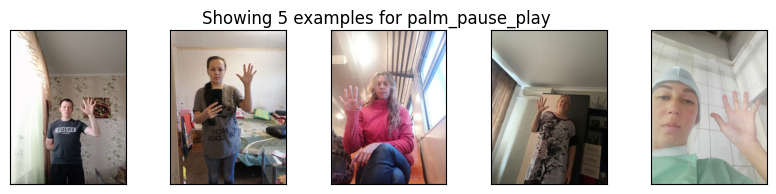

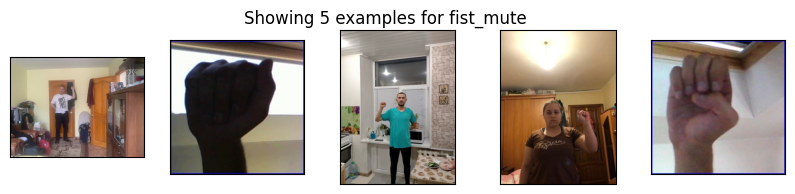

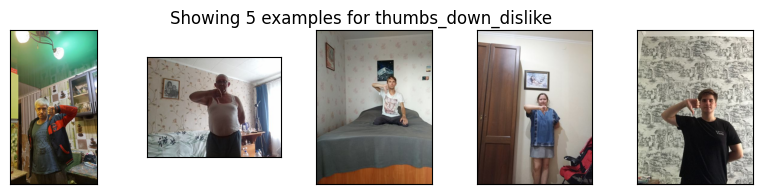

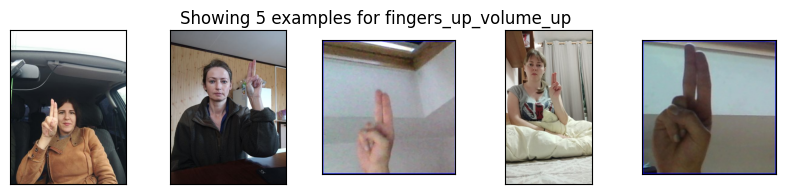

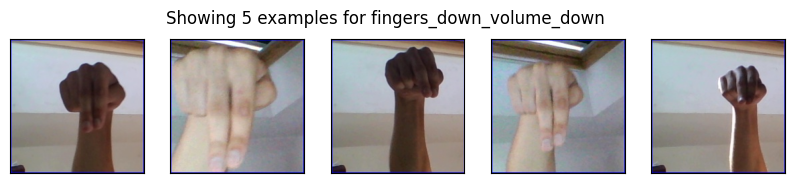

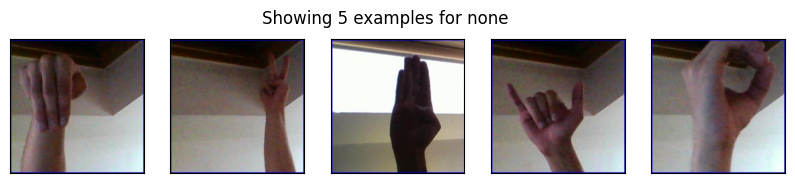

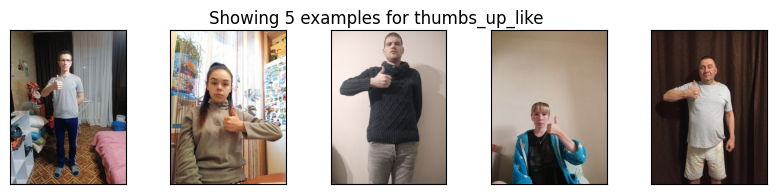

In [ ]:
NUM_EXAMPLES = 5

for label in labels:
    label_dir = os.path.join(dataset_path, label)
    example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
    fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
    for i in range(NUM_EXAMPLES):
        axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
    fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()

## Model

**Load the dataset**

Load the dataset located at `dataset_path` by using the `Dataset.from_folder` method. When loading the dataset, run the pre-packaged hand detection model from MediaPipe Hands to detect the hand landmarks from the images. Any images without detected hands are ommitted from the dataset. The resulting dataset will contain the extracted hand landmark positions from each image, rather than images themselves.

Additional information: https://ai.google.dev/edge/api/mediapipe/python/mediapipe_model_maker/gesture_recognizer

In [12]:
data = gesture_recognizer.Dataset.from_folder(
    dirname=dataset_path,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)

**Split the dataset**

80% for training, 10% for validation, and 10% for testing

In [13]:
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

**Train the model**

Train the custom gesture recognizer by using the create method and passing in the training data, validation data, model options, and hyperparameters.

In [14]:
hparams = gesture_recognizer.HParams(export_dir="exported_model")
options = gesture_recognizer.GestureRecognizerOptions(hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer  [(None, 128)]             0         
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 custom_gesture_recognizer_  (None, 7)                 903       
 out (Dense)                                                     
                                                             

**Evaluate the model performance**

After training the model, evaluate it on a test dataset and print the loss and accuracy metrics.

In [15]:
loss, acc = model.evaluate(test_data, batch_size=1)
print(f"Test loss:{loss}, Test accuracy:{acc}")

923/923 [==============================] - 7s 2ms/step - loss: 0.2209 - categorical_accuracy: 0.9187
Test loss:0.22085508704185486, Test accuracy:0.9187432527542114


## **Export the Model**

After creating the model, convert and export it to a Tensorflow Lite model format for later use on an on-device application. The export also includes model metadata, which includes the label file.

In [17]:
model.export_model()

Using existing files at /tmp/model_maker/gesture_recognizer/palm_detection_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/hand_landmark_full.tflite


In [19]:
files.download('exported_model/gesture_recognizer.task')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>